Here I take the data cleaning from the gbm ftw and see if I can get better results.

In [32]:
library(ggplot2)
library(dplyr)
library(xgboost)
library(lubridate)
library(ranger)
library(gbm)

Loading required package: survival
Loading required package: lattice
Loading required package: splines
Loading required package: parallel
Loaded gbm 2.1.1


In [7]:
train <- read.csv("train.csv")

In [18]:
2+2

Observations: 26,729
Variables: 31
$ DateTime                        (dbl) 1392250920, 1381686240, 1422728880,...
$ OutcomeType                     (fctr) Return_to_owner, Euthanasia, Adopt...
$ AnimalType                      (fctr) Dog, Cat, Dog, Cat, Dog, Dog, Cat,...
$ SexuponOutcome                  (fctr) Neutered Male, Spayed Female, Neut...
$ AgeuponOutcome                  (dbl) 10000, 10000, 20000, 30, 20000, 100...
$ Hour                            (int) 18, 12, 12, 19, 12, 13, 13, 17, 17,...
$ Weekday                         (dbl) 4, 1, 7, 6, 6, 6, 7, 5, 3, 7, 5, 2,...
$ NameLen                         (int) 7, 5, 6, 0, 0, 4, 5, 0, 4, 0, 0, 0,...
$ NameWeirdness                   (int) 5, 16, 2, 7691, 7691, 11, 10, 7691,...
$ col.Black                       (lgl) FALSE, FALSE, FALSE, FALSE, FALSE, ...
$ col.White                       (lgl) TRUE, FALSE, TRUE, FALSE, FALSE, FA...
$ col.Brown                       (lgl) TRUE, FALSE, FALSE, FALSE, FALSE, F...
$ col.Blue       

Data cleaning and feature creation from: https://www.kaggle.com/jamesdlawrence/shelter-animal-outcomes/gbm-ftw/run/189411

In [11]:
popularBreeds <- names(summary(train$Breed,maxsum=10L))
trainNameSummary <- summary(train$Name,maxsum=Inf)

clean <- function(x){
	x$Hour <- hour(x$DateTime)
	x$Weekday <- wday(x$DateTime)
	x$DateTime <- as.numeric(as.POSIXct(x$DateTime))
	x$OutcomeSubtype <- NULL
	x$NameLen <- nchar(as.character(x$Name))
	x$NameWeirdness <- trainNameSummary[match(x$Name,names(trainNameSummary))]
	x$Name <- NULL
	x$AgeuponOutcome <- gsub(" years?","0000",x$AgeuponOutcome)
	x$AgeuponOutcome <- gsub(" months?","00",x$AgeuponOutcome)
	x$AgeuponOutcome <- gsub(" weeks?","0",x$AgeuponOutcome)
	x$AgeuponOutcome <- gsub(" days?","",x$AgeuponOutcome)
	x$AgeuponOutcome <- as.numeric(paste0("0",x$AgeuponOutcome))
	x$AnimalID <- NULL
	for(i in c("Black","White","Brown","Blue","Orange","Calico","Chocolate","Gold","Red","Tan","Tortie","Yellow")) x[[paste0("col.",i)]] <- grepl(i,x$Color)
	x$Color <- NULL
	for(i in popularBreeds) x[[paste0("breed.",make.names(i))]] <- x$Breed == i
	x$Breed <- NULL
	x
}

train <- clean(train)

In [12]:
head(train)

,DateTime,OutcomeType,AnimalType,SexuponOutcome,AgeuponOutcome,Hour,Weekday,NameLen,NameWeirdness,col.Black,ellip.h,breed.Domestic.Shorthair.Mix,breed.Pit.Bull.Mix,breed.Chihuahua.Shorthair.Mix,breed.Labrador.Retriever.Mix,breed.Domestic.Medium.Hair.Mix,breed.German.Shepherd.Mix,breed.Domestic.Longhair.Mix,breed.Siamese.Mix,breed.Australian.Cattle.Dog.Mix,breed.X.Other.
1,1392250920,Return_to_owner,Dog,Neutered Male,10000,18,4,7,5,FALSE,⋯,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
2,1381686240,Euthanasia,Cat,Spayed Female,10000,12,1,5,16,FALSE,⋯,TRUE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
3,1422728880,Adoption,Dog,Neutered Male,20000,12,7,6,2,FALSE,⋯,FALSE,TRUE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
4,1405123740,Transfer,Cat,Intact Male,30,19,6,0,7691,FALSE,⋯,TRUE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
5,1384541520,Transfer,Dog,Neutered Male,20000,12,6,0,7691,FALSE,⋯,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
6,1398449040,Transfer,Dog,Intact Female,100,13,6,4,11,TRUE,⋯,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE


In [14]:
model_ranger <- ranger(OutcomeType ~., data = train)

Growing trees.. Progress: 90%. Estimated remaining time: 3 seconds.


In [15]:
model_ranger

Ranger result

Call:
 ranger(OutcomeType ~ ., data = train) 

Type:                             Classification 
Number of trees:                  500 
Sample size:                      26729 
Number of independent variables:  30 
Mtry:                             5 
Target node size:                 1 
Variable importance mode:         none 
OOB prediction error:             31.84 % 

Now let's do probability trees. Notice the decrease in OOB error, roughly around 4%!

In [16]:
ranger(OutcomeType ~., data = train, probability = TRUE, num.trees = 200)

Ranger result

Call:
 ranger(OutcomeType ~ ., data = train, probability = TRUE, num.trees = 200) 

Type:                             Probability estimation 
Number of trees:                  200 
Sample size:                      26729 
Number of independent variables:  30 
Mtry:                             5 
Target node size:                 10 
Variable importance mode:         none 
OOB prediction error:             0.2750909 

In [40]:
model_ranger <- ranger(OutcomeType ~., data = train, probability = TRUE, num.trees = 300, mtry = 15)

Growing trees.. Progress: 58%. Estimated remaining time: 22 seconds.


In [39]:
ranger(OutcomeType ~., data = train, probability = TRUE, num.trees = 300, mtry = 20)

Growing trees.. Progress: 36%. Estimated remaining time: 55 seconds.
Growing trees.. Progress: 79%. Estimated remaining time: 16 seconds.


Ranger result

Call:
 ranger(OutcomeType ~ ., data = train, probability = TRUE, num.trees = 300,      mtry = 20) 

Type:                             Probability estimation 
Number of trees:                  300 
Sample size:                      26729 
Number of independent variables:  30 
Mtry:                             20 
Target node size:                 10 
Variable importance mode:         none 
OOB prediction error:             0.2607829 

Let's try Xgboost:

In [26]:
design_matrix <- model.matrix(OutcomeType ~ ., data = train)
y <- as.numeric(train$OutcomeType) - 1

In [35]:
xgb.cv(data = design_matrix, label = y, max_depth = 6,
                nrounds = 500,
                eta = 0.05,
                objective = "multi:softprob", 
                num_class = 5, nfold = 5) -> cv 

[0]	train-merror:0.331700+0.004846	test-merror:0.341763+0.011423
[1]	train-merror:0.329988+0.003686	test-merror:0.340267+0.010884
[2]	train-merror:0.329474+0.003910	test-merror:0.339593+0.012015
[3]	train-merror:0.329184+0.004262	test-merror:0.340154+0.011413
[4]	train-merror:0.327884+0.003644	test-merror:0.338845+0.012661
[5]	train-merror:0.326153+0.003370	test-merror:0.337124+0.013177
[6]	train-merror:0.326238+0.003071	test-merror:0.336937+0.013377
[7]	train-merror:0.326181+0.002801	test-merror:0.337161+0.013796
[8]	train-merror:0.326153+0.002719	test-merror:0.337274+0.014072
[9]	train-merror:0.325817+0.002686	test-merror:0.336750+0.013714
[10]	train-merror:0.325910+0.002679	test-merror:0.336600+0.014045
[11]	train-merror:0.325405+0.002936	test-merror:0.335964+0.014203
[12]	train-merror:0.325124+0.002728	test-merror:0.335889+0.014515
[13]	train-merror:0.324657+0.002897	test-merror:0.335403+0.015119
[14]	train-merror:0.323862+0.004170	test-merror:0.334842+0.014610
[15]	train-merror:0.

[1] 421

[1] 0.303902

ERROR: Error in file(con, "rb"): cannot open the connection


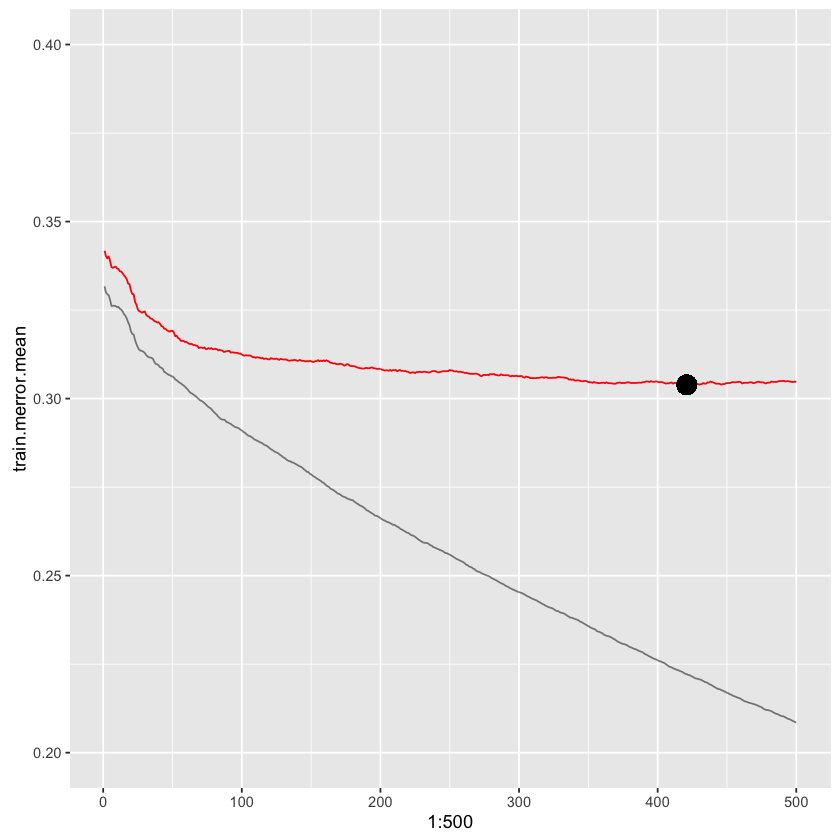

In [37]:
which.min(cv$test.merror.mean)

min(cv$test.merror.mean)
    
ggplot(cv, aes(x = 1:500)) +
    geom_line(aes(y = train.merror.mean), alpha = 0.5) +
    geom_line(aes(y = test.merror.mean), color = "red") +
    geom_point(aes(x = which.min(cv$test.merror.mean),
                   y = min(cv$test.merror.mean)), size = 5)+
    ylim(c(0.2, 0.4))

In [ ]:
2+2